# Setup environment

In [1]:
import tensorflow as tf
import numpy as np
from vizdoom import *

import random
import time
from skimage import transform
from datetime import datetime

from collections import deque
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)

with tf.Session() as sess:
    print (sess.run(c))
    
with tf.Session() as sess:
  devices = sess.list_devices()

print(devices)

[[22. 28.]
 [49. 64.]]
[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 1154133952554002530), _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 17311287738914215129), _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 9706294730617260535), _DeviceAttributes(/job:localhost/replica:0/task:0/device:GPU:0, GPU, 5452267520, 10271867046152174296)]


In [3]:
def create_environment(visible=False):
    game = DoomGame()
    game.load_config("scenarios/deadly_corridor.cfg")
                                
    game.set_window_visible(visible)
    
    game.init()
    
    possible_actions = np.identity(7, dtype=int).tolist()
    
    return game, possible_actions

In [4]:
game, possible_actions = create_environment(visible=False)

In [5]:
def test_environment(game, actions):
    episodes = 10
    for i in range(episodes):
        game.new_episode()
        while not game.is_episode_finished():
            state = game.get_state()
            img = state.screen_buffer
            misc = state.game_variables
            action = random.choice(actions)
            #print(action)
            reward = game.make_action(action)
            #print ("\treward:", reward)
            time.sleep(0.007)
        print ("Result:", game.get_total_reward())
        time.sleep(1)
    game.close()

In [6]:
#test_environment(game, possible_actions)

# Util functions

In [7]:
def preprocess_frame(frame):
    cropped_frame = frame[15:-5,20:-20]
    normalized_frame = cropped_frame/255.0
    resized_frame = transform.resize(normalized_frame, [100, 120])
    return resized_frame

In [8]:
stack_size = 4

def init_deque():
    return deque([np.zeros((100, 120), dtype=np.int) for i in range(stack_size)], maxlen=4)

stacked_frames = init_deque()

def stack_frames(stacked_frames, state, is_new_episode):
    frame = preprocess_frame(state)
    
    if is_new_episode:
        stacked_frames = init_deque()
        for _ in range(4):
            stacked_frames.append(frame)
            
    else:
        stacked_frames.append(frame)
        
    stacked_state = np.stack(stacked_frames, axis=2)
    
    return stacked_state, stacked_frames

# Setup hyperparams

In [9]:
### MODEL
state_size = [100,120,4]
action_size = game.get_available_buttons_size()
learning_rate = 25e-5

### TRAINING
total_episodes = 50000
max_steps = 5000
batch_size = 64

# FIXED Q TARGETS
max_tau = 10000

# EXPLORATION for epsilon greedy strategy
explore_start = 1.0
explore_stop = 0.01
decay_rate = 5e-5

# Q LEARNING
gamma = 0.95 # Discounting rate

### MEMORY
## If you have GPU change to 1 million
pretrain_length = 1000000
memory_size = 16000

### MODIFY THIS TO FALSE IF YOU JUST WANT TO SEE THE TRAINED AGENT
training = True

## TURN THIS TO TRUE IF YOU WANT TO RENDER THE ENVIRONMENT
episode_render = False

# Setup network

In [10]:
class DDDQNNet:
    def __init__(self, state_size, action_size, learning_rate, name):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.name = name
        
        with tf.variable_scope(self.name):
            tempArray = [None]
            for i in state_size:
                tempArray.append(i)
            
            self.inputs_ = tf.placeholder(tf.float32, tempArray, name="inputs")
            #self.inputs_ = tf.placeholder(tf.float32, [None, *state_size], name="inputs")
            
            self.ISWeights_ = tf.placeholder(tf.float32, [None, 1], name="IS_weights")
            self.actions_ = tf.placeholder(tf.float32, [None, action_size], name="actions_")
            self.target_Q = tf.placeholder(tf.float32, [None], name="target")
            
            """
            First convnet
            CNN
            ELU
            """
            # Input is 100x120x4
            self.conv1 = tf.layers.conv2d(inputs = self.inputs_,
                                         filters = 32,
                                         kernel_size = [8,8],
                                         strides=[4,4],
                                         padding="VALID",
                                         kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                         name="conv1")
            self.conv1_out = tf.nn.elu(self.conv1, name="conv1_out")
            
            """
            Second convnet
            CNN
            ELU
            """
            self.conv2 = tf.layers.conv2d(inputs = self.conv1_out,
                                         filters = 64,
                                         kernel_size = [4,4],
                                         strides = [2,2],
                                         padding = "VALID",
                                         kernel_initializer = tf.contrib.layers.xavier_initializer_conv2d(),
                                         name = "conv2")
            self.conv2_out = tf.nn.elu(self.conv2, name = "conv2_out")
            
            """
            Third convnet
            CNN
            ELU
            """
            self.conv3 = tf.layers.conv2d(inputs = self.conv2_out,
                                         filters = 128,
                                         kernel_size = [4,4],
                                         strides = [2,2],
                                         padding = "VALID",
                                         kernel_initializer = tf.contrib.layers.xavier_initializer_conv2d(),
                                         name = "conv3")
            self.conv3_out = tf.nn.elu(self.conv3, name="conv3_out")
            
            self.flatten = tf.layers.flatten(self.conv3_out)
            
            ## Here we separate into two streams
            # The one that calculates V(s)
            self.value_fc = tf.layers.dense(inputs = self.flatten,
                                           units = 512,
                                           activation = tf.nn.elu,
                                           kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                           name="value_fc")
            self.value = tf.layers.dense(inputs=self.value_fc,
                                        units=1,
                                        activation=None,
                                        kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                        name="value")
            
            # The one that calculates A(s, a)
            self.advantage_fc = tf.layers.dense(inputs=self.flatten,
                                               units=512,
                                               activation=tf.nn.elu,
                                               kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                               name="advantage_fc")
            self.advantage = tf.layers.dense(inputs=self.advantage_fc,
                                            units = self.action_size,
                                            activation=None,
                                            kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                            name="advantages")
            
            # Aggregating layer
            # Q(s,a) = V(s) + (A(s,a) - 1/|A|*sum A(s,a'))
            self.output = self.value + tf.subtract(self.advantage, tf.reduce_mean(self.advantage, axis=1, keepdims=True))
            
            # Q is out predicted Q value.
            self.Q = tf.reduce_sum(tf.multiply(self.output, self.actions_), axis=1)
            
            # The loss is the difference between our predicted Q_values and the Q_target
            self.absolute_errors = tf.abs(self.target_Q - self.Q)# 
            
            # Sum(Qtarget - Q)^2
            self.loss = tf.reduce_mean(tf.square(self.target_Q - self.Q))
            
            self.optimizer = tf.train.RMSPropOptimizer(self.learning_rate).minimize(self.loss)    

In [11]:
# Reset the graph
tf.reset_default_graph()

# Instantiate the DQNetwork
DQNetwork = DDDQNNet(state_size, action_size, learning_rate, name="DQNetwork")

# Instantiate the target network
TargetNetwork = DDDQNNet(state_size, action_size, learning_rate, name="TargetNetwork")


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use tf.cast instead.


In [12]:
class SumTree(object):
    data_pointer = 0
    
    """
    Here we initialize the tree with all nodes = 0, 
    and initialize the data with all values = 0
    """
    def __init__(self, capacity):
        self.capacity = capacity # Number of leaf nodes that contains experiences
        """
        Generate the tree with all nodes values = 0
        To understand this calculation (2 * capacity - 1) 
        look at the schema above.
        Rememeber we are in a binary node (each node has 
        max 2 children) so 2x.
        of leaf (capacity) - 1 (root node).
        Parent nodes = capacity - 1.
        Leaf nodes = capacity.
        """
        self.tree = np.zeros(2 * capacity - 1)
        
        """
        tree:
            0
           / \
          0   0
         / \ / \
        0  0 0  0 [Size: capacity] it's at this line we have the priority scores
        """
        
        # Contains the experiences (so the size of the data equals capacity)
        self.data = np.zeros(capacity, dtype=object)
        
    """
    Here we add our priority score to the sumtree leaf 
    and the experience to data
    """
    def add(self, priority, data):
        # Look at what index we want to put the experience
        tree_index = self.data_pointer + self.capacity - 1
        
        """ tree:
            0
           / \
          0   0
         / \ / \
tree_index 0 0 0  We fill the leaves from left to right
        """
        
        # Update data frame
        self.data[self.data_pointer] = data
        
        # Update the leaf
        self.update(tree_index, priority)
        
        self.data_pointer += 1
        
        # If we're above the capacity, go back to first index
        if self.data_pointer >= self.capacity:
            self.data_pointer = 0
        
    """
    Update the leaf priority score and propagate the change 
    through the tree
    """
    def update(self, tree_index, priority):
        # Change = new priority score - former priority score
        change = priority - self.tree[tree_index]
        self.tree[tree_index] = priority
        
        # then propagate the change through the tree
        while tree_index != 0:
            
            """
            Here we want to access the line above
            THE NUMBERS IN THIS TREE ARE THE INDEXES NOT THE PRIORITY VALUES
            
                0
               / \
              1   2
             / \ / \
            3  4 5  [6] 
            
            If we are in leaf at index 6, we updated the priority score
            We need then to update index 2 node
            So tree_index = (tree_index - 1) // 2
            tree_index = (6-1)//2
            tree_index = 2 (because // round the result)
            """
            tree_index = (tree_index - 1) // 2
            self.tree[tree_index] += change
            
    """
    Here we get the leaf_index, priority value of that leaf and experience associated with that index
    """
    def get_leaf(self, v):
        """
        Tree structure and array storage:
        Tree index:
             0         -> storing priority sum
            / \
          1     2
         / \   / \
        3   4 5   6    -> storing priority for experiences
        Array type for storing:
        [0,1,2,3,4,5,6]
        """
        parent_index = 0
        
        while True: #the while loop is faster than the method in the reference code
            left_child_index = 2 * parent_index + 1
            right_child_index = left_child_index + 1
            
            # If we reach bottom, end the search
            if left_child_index >= len(self.tree):
                leaf_index = parent_index
                break
            
            else: # downward search, always search for a higher priority node
                
                if v <= self.tree[left_child_index]:
                    parent_index = left_child_index
                
                else:
                    v -= self.tree[left_child_index]
                    parent_index = right_child_index
        
        data_index = leaf_index - self.capacity + 1
        
        return leaf_index, self.tree[leaf_index], self.data[data_index]
    
    @property
    def total_priority(self):
        return self.tree[0] # Returns the root node 
        

Here we don't use deque anymore

In [13]:
class Memory(object): # stored as (s, a, r, s_) in SumTree
    """
    This SumTree code is modified version and the original code is from:
    https://github.com/jaara/AI-blog/blob/master/Seaquest-DDQN-PER.py
    """
    PER_e = 0.01 # Hyperparameter that we use to avoid some experiences to have 0 probability of being taken
    PER_a = 0.6 # Hyperparameter that we use to make tradeoff between taking only experiences with hight probabilities and sampling randomly
    PER_b = 0.4 # Importance-sampling, from initial value increasing to 1
    
    PER_b_increment_per_sampling = 0.001
    
    absolute_error_upper = 1. # clipped as abs error
    
    def __init__(self, capacity):
        # Making the tree
        """
        Remember that our tree is composed of a sum tree that contains the priority scores at it's leaf nodes
        And also a data array
        We don't use deque because it means that at each timestep our experiences change index by one.
        We prefer to use a simple array and to overwrite when the memory is full.
        """
        self.tree = SumTree(capacity)
        
    """
    Store a new experience in our tree
    Each new experience have a score of max_prority (it will be then improved when we use this exp to train our DDQN)
    """
    def store(self, experience):
        # Find the max priority
        max_priority = np.max(self.tree.tree[-self.tree.capacity:])
        
        # If max priority = 0 we can't set priority = 0 since this exp will never have a chance to be selected
        # So we use a minimum priority
        if max_priority == 0:
            max_priority = self.absolute_error_upper
            
        self.tree.add(max_priority, experience) # set the max p for new p
        
    """
    - First, to sample a minibatch of size k, the range [0, priority_total] is divided into k ranges.
    - Then, a value is uniformly sampled from each range.
    - We then search in the sumtree, the experiences where the priority score correspond to sample values are retrived from.
    - Then, we calculate IS weights for each minibatch element
    """
    def sample(self, n):
        # Create a sample array that will contain the minibatch
        memory_b = []
        
        b_idx, b_ISWeights = np.empty((n,), dtype=np.int32), np.empty((n,1), dtype=np.float32)
        
        # Calculate the priority segment
        # Here, as explained in the paper, we divide the Range[0, ptotal] into n ranges
        priority_segment = self.tree.total_priority / n # priority segment
        
        # We increase the PER_b each time we sample a new minibatch
        self.PER_b = np.min([1., self.PER_b + self.PER_b_increment_per_sampling]) # max = 1
        
        # Calc the max_weight
        p_min = np.min(self.tree.tree[-self.tree.capacity:]) / self.tree.total_priority
        max_weight = (p_min * n) ** (-self.PER_b)
        
        for i in range(n):
            """
            A value is uniformly sampled from each range
            """
            a, b = priority_segment * i, priority_segment * (i + 1)
            value = np.random.uniform(a, b)
            
            """
            Experience that correspond to each value is retrieved
            """
            index, priority, data = self.tree.get_leaf(value)
            
            #P(j)
            sampling_probabilities = priority / self.tree.total_priority
            
            # IS = (1/N * 1/P(i))**b /max wi == (N*P(i))**-b /max wi
            b_ISWeights[i,0] = np.power(n * sampling_probabilities, -self.PER_b)/max_weight
            
            b_idx[i] = index
            experience = [data]
            memory_b.append(experience)
        
        return b_idx, memory_b, b_ISWeights
    
    """
    Update the prioritues on the tree
    """
    def batch_update(self, tree_idx, abs_errors):
        abs_errors += self.PER_e 
        clipped_errors = np.minimum(abs_errors, self.absolute_error_upper) # convert to abs and avoid 0
        ps = np.power(clipped_errors, self.PER_a)
        
        for ti, p in zip(tree_idx, ps):
            self.tree.update(ti, p)    

Here we'll deal with the empty memory problem: we pre-populate our memory by taking random actions and storing the experience

In [14]:
#plt.imshow(np.rollaxis(state, 0, 3))

In [15]:
pretrain_length

1000000

In [16]:
# Instantiate memory
memory = Memory(memory_size)

# Render the environment
game.new_episode()

for i in range(pretrain_length):
    # If it's the first step
    if i%50000 == 0:
        print i
    
    if i == 0:
        # First we need a state
        state = game.get_state().screen_buffer
        state, stacked_frames = stack_frames(stacked_frames, state, True)
        
    # Random action
    action = random.choice(possible_actions)
    
    # Get the rewards
    reward = game.make_action(action)
    
    done = game.is_episode_finished()
    
    if done:
        # We finished the episode
        next_state = np.zeros(state.shape)
        
        # Add experience to memory
        experience = state, action, reward, next_state, done
        memory.store(experience)
        
        game.new_episode()
        
        state = game.get_state().screen_buffer
        
        # Stack the frames
        state, stacked_frames = stack_frames(stacked_frames, state, is_new_episode=True)
        
    else:
        # Get the next state
        next_state = game.get_state().screen_buffer
        next_state, stacked_frames = stack_frames(stacked_frames, next_state, is_new_episode=False)
        
        # Add experience to memory
        experience = state, action, reward, next_state, done
        memory.store(experience)
        
        # Our state is now the next_state
        state = next_state        
        

0
50000
100000
150000
200000
250000
300000
350000
400000
450000
500000
550000
600000
650000
700000
750000
800000
850000
900000
950000


## Step 7: Set up Tensorboard

to launch tensorboard : tensorboard --logdir=/tensorboard/dddqn/1

In [17]:
# Setup TensorBoard Writer
writer = tf.summary.FileWriter("/tensorboard/dddwn/1")

## Losses
tf.summary.scalar("Loss", DQNetwork.loss)

write_op = tf.summary.merge_all()

## Step 8: Train our agent 🏃🏻‍♂️
Our algorithm:

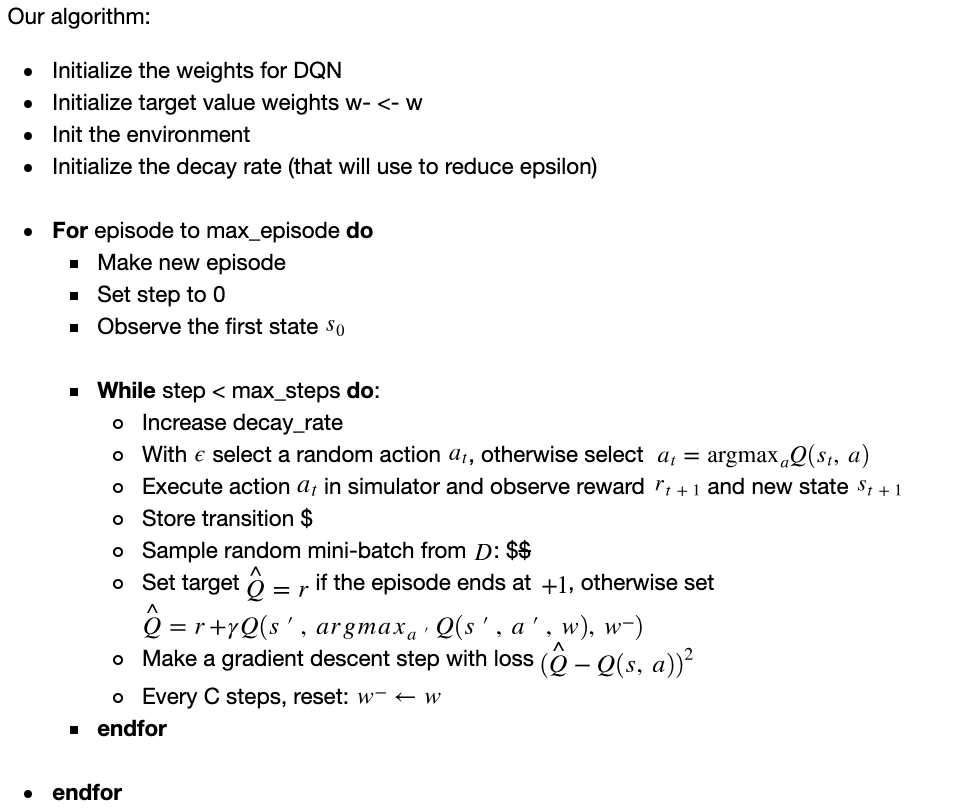

In [18]:
"""
This function will do the part
With ϵ select a random action at=at, otherwise select at=argmaxaQ(st,a)
"""
def predict_action(explore_start, explore_stop, decay_rate, decay_step, state, actions):
    ## EPSILON GREEDY STRATEGY
    # Choose action a from state s using epsilon greedy.
    ## First we randomize a number
    exp_exp_tradeoff = np.random.rand()
    
    # Here we'll use an improve version of our epsilon greedy strategy used in Q-learning notebook
    explore_probabilty = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * decay_step)
    
    if (explore_probabilty > exp_exp_tradeoff):
        # Perform random action
        action = random.choice(possible_actions)
    else:
        # Get action from Q-network
        # Estimate the Qs values state
        #Qs = sess.run(DQNetwork.output, feed_dict = {DQNetwork.inputs_: state.reshape((1, *state.shape))})
        #Fix
        temp = [1]
        for i in state.shape:
            temp.append(i)
        Qs = sess.run(DQNetwork.output, feed_dict = {DQNetwork.inputs_: state.reshape((temp))})
        
        
        
        choice = np.argmax(Qs)
        action = possible_actions[int(choice)]
        
    return action, explore_probabilty

In [19]:
"""
This function helps os to copy one set of variables to another
In our case we use it when we want to copy the parameters of DQN to Target_network
"""
def update_target_graph():
    
    # Get the parameters of our DQNNetwork
    from_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "DQNetwork")
    
    # Get the parameters of our Target_network
    to_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "TargetNetwork")
    
    op_holder = []
    
    # Update our target_network parameters with DQNNetwork parameters
    for from_var, to_var in zip(from_vars, to_vars):
        op_holder.append(to_var.assign(from_var))
    return op_holder

In [ ]:
# Saver will help us to save our model
saver = tf.train.Saver()
# Keep track of all rewards total for each batch
allRewards = []

total_rewards = 0
maximumRewardRecorded = 0
mean_reward_total = []
epoch = 1
average_reward = []


now = datetime.now()
date_time = now.strftime("%m/%d/%Y, %H:%M:%S")

with open("logs/runningTimeDDDQN.txt", "a") as myfile:
    myfile.write("Starting:\n")
    myfile.write("date and time:" + date_time + "\n")



if training == True:
    with tf.Session() as sess:
        # Init variables 
        sess.run(tf.global_variables_initializer())
        
        # Init decay rate (that we will use to reduce epsilon)
        decay_step = 0
        
        tau = 0
        
        game.init()
        
        # Update the parameters of our TargetNetwork
        update_target = update_target_graph()
        sess.run(update_target)
        
        for episode in range(total_episodes):
            
            step = 0
            
            # Init the rewards of the episode
            episode_rewards = []
            
            game.new_episode()
            
            state = game.get_state().screen_buffer
            
            # Remember that stack frame function also call our preprocess function.
            state, stacked_frames = stack_frames(stacked_frames, state, True)
            
            while step < max_steps:
                step += 1
                
                # Increase the C step
                tau += 1
                
                # Increase decay_step
                decay_step += 1
                
                # With ϵ select a random action at = at, otherwise select a = argmaxQ(st,a)
                action, explore_probability = predict_action(explore_start, explore_stop, decay_rate, decay_step, state, possible_actions)
                
                # Perform the action
                reward = game.make_action(action)
                
                done = game.is_episode_finished()
                
                # Add the reward to total reward
                episode_rewards.append(reward)
                
                # If the game is finished
                if done:
                    # the episode ends so no next state
                    next_state = np.zeros((120, 140), dtype=np.int)
                    next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
                    
                    # Set step = max_steps to end the episode
                    step = max_steps
                    
                    # Get the total reward of the episode
                    total_reward = np.sum(episode_rewards)
                    
                    #print('Episode: {}'.format(episode),
                    #     'Total reward: {}'.format(total_reward),
                    #     'Training loss: {:.4f}'.format(loss),
                    #     'Explore P: {:.4f}'.format(explore_probability))
                    
                    
                     ### These part is used for analytics
                    # Calculate the total reward ot the batch
                    total_reward_of_that_batch = np.sum(total_reward)
                    allRewards.append(total_reward_of_that_batch)

                    # Calculate the mean reward of the batch
                    # Total rewards of batch / nb episodes in that batch
                    mean_reward_of_that_batch = np.divide(total_reward_of_that_batch, batch_size)
                    mean_reward_total.append(mean_reward_of_that_batch)

                    # Calculate the average reward of all training
                    # mean_reward_of_that_batch / epoch
                    average_reward_of_all_training = np.divide(np.sum(mean_reward_total), episode)

                    # Calculate maximum reward recorded 
                    maximumRewardRecorded = np.amax(allRewards)

                    
                    
                    
                    
                    print("==========================================")
                    print("Epoch: ", episode, "/", total_episodes)
                    print("-----------")
                    print("Number of training episodes: {}".format(batch_size))
                    print("Total reward: {}".format(total_reward_of_that_batch, batch_size))
                    print("Mean Reward of that batch {}".format(mean_reward_of_that_batch))
                    print("Average Reward of all training: {}".format(average_reward_of_all_training))
                    print("Max reward for a batch so far: {}".format(maximumRewardRecorded))

                    
                    
                    
                    print "Episode: %f  Total reward: %f  Training loss: %f  Explore P: %f  " %(episode,total_reward,loss,explore_probability)    
                    
                    
                    # Add experience to memory
                    experience = state, action, reward, next_state, done
                    memory.store(experience)
                    
                else:
                    # Get the next state
                    next_state = game.get_state().screen_buffer
                    
                    # Stack the frame of the next_state
                    next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
                    
                    # Add experience to memory
                    experience = state, action, reward, next_state, done
                    memory.store(experience)
                    
                    # state+1 is now our current state
                    state = next_state
                    
                ### LEARNING PART
                # Obtain random mini-batch from memory
                tree_idx, batch, ISWeights_mb = memory.sample(batch_size)
                
                states_mb = np.array([each[0][0] for each in batch], ndmin=3)
                actions_mb = np.array([each[0][1] for each in batch])
                rewards_mb = np.array([each[0][2] for each in batch])
                next_states_mb = np.array([each[0][3] for each in batch], ndmin=3)
                dones_mb = np.array([each[0][4] for each in batch])
                
                target_Qs_batch = []
                
                ### DOUBLE DQN Logic
                # Use DQNNetwork to select the action to take at next_state (a') (action with the highest Q-value)
                # Use TargetNetwork to calculate the Q_val of Q(s', a')
                # Get Q values for next_state
                q_next_state = sess.run(DQNetwork.output, feed_dict = {DQNetwork.inputs_: next_states_mb})
                
                # Calculate Qtarget for all action at that state
                q_target_next_state = sess.run(TargetNetwork.output, feed_dict = {TargetNetwork.inputs_: next_states_mb})
                
                # Set Q_target = r if the episode ends at s+1, otherwise set Q_target = r + gamma * Qtarget(s',a')
                for i in range(0, len(batch)):
                    terminal = dones_mb[i]
                    
                    # We got a'
                    action = np.argmax(q_next_state[i])
                    
                    # If we are in a terminal state, only equals reward
                    if terminal:
                        target_Qs_batch.append(rewards_mb[i])
                        
                    else:
                        # Take the Qtarget for action a'
                        target = rewards_mb[i] + gamma * q_target_next_state[i][action] 
                        target_Qs_batch.append(target) 
                # shouldn't the action be chosen from the targetnetwork and the q-value be taken from the original network??
                # Also is this even a double dqn? isn't it just fixed target logic??
                target_mb = np.array([each for each in target_Qs_batch]) # What does this get us?
                
                _, loss, absolute_errors = sess.run([DQNetwork.optimizer, DQNetwork.loss, DQNetwork.absolute_errors],
                                                   feed_dict={DQNetwork.inputs_: states_mb,
                                                             DQNetwork.target_Q: target_mb,
                                                             DQNetwork.actions_: actions_mb,
                                                             DQNetwork.ISWeights_: ISWeights_mb})
                
                # Update priority
                memory.batch_update(tree_idx, absolute_errors)
                
                # Write TF Summaries
                summary = sess.run(write_op, feed_dict={DQNetwork.inputs_: states_mb,
                                                       DQNetwork.target_Q: target_mb,
                                                       DQNetwork.actions_: actions_mb,
                                                       DQNetwork.ISWeights_: ISWeights_mb})
                writer.add_summary(summary, episode)
                writer.flush()
                
                if tau > max_tau:
                    # Update the parameters of our TargetNetwork with DQN_weights
                    update_target = update_target_graph()
                    sess.run(update_target)
                    tau = 0
                    print("Model updated")
                    
            # Save model every 5 episodes
            if episode % 5 == 0:
                save_path = saver.save(sess, "./models/modelDDDQN.ckpt")
                print("Model Saved")
                now = datetime.now()
                date_time = now.strftime("%m/%d/%Y, %H:%M:%S")
                with open("logs/runningTimeDDDQN.txt", "a") as myfile:
                    myfile.write("date and time:" + date_time + "\n")


## Step 9: Watch our Agent play

Now that we trained our agent, we can test it

In [ ]:
with tf.Session() as sess:
    
    game, possible_actions = create_environment(visible=True)
    
    # Load the model
    saver.restore(sess, "./model/modelDDDQN.ckpt")
    game.init()
    
    for i in range(10):
        
        game.new_episode()
        state = game.get_state().screen_buffer
        state, stacked_frames = stack_frames(stacked_frames, state, True)
        
        while not game.is_episode_finished():
            ## EPSILON GREEDY STRATEGY
            # Choose action a from state s using epsilon greedy.
            ## First we randomize a number
            exp_exp_tradeoff = np.random.rand()
            
            explore_probability = 0.01
            
            if (explore_probability > exp_exp_tradeoff):
                # Make a random action (exploration)
                action = random.choice(possible_actions)
                
            else:
                # Get action from Q-network (exploitation)
                # Estimate the Qs values state
                Qs = sess.run(DQNetwork.output, feed_dict = {DQNetwork.inputs_: state.reshape((1,*state.shape))})
                
                # Take the biggest Q value (= the best action)
                choice = np.argmax(Qs)
                action = possible_actions[int(choice)]
            
            game.make_action(action)
            done = game.is_episode_finished()
            
            if done:
                break
            
            else:
                next_state = game.get_state().screen_buffer
                next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
                state = next_state
                
        score = game.get_total_reward()
        print("Score: ", score)
        
    game.close()